##Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import brain
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

##Load true image

In [3]:
plt.ion()
brainimage = brain()

# Dimensions of image
nxd = 128

true_object_np = resize(brainimage[9, 30: -1, : -30], (nxd, nxd), anti_aliasing=False)

##Define functions

In [4]:
# Number of viewing angles in the sinogram
nphi = int(nxd * 1.42)

# Number of pixels in the radial dimension
nrd = int(nxd * 1.42)

# System matrix as a numpy array
def make_numpy_system_matrix(nxd, nrd, nphi):
    system_matrix = np.zeros((nrd * nphi, nxd * nxd))  # Rows = num of sinogram bins, Cols = num of image pixels
    for xv in range(nxd):
        for yv in range(nxd):   # select pixel with coordinates (xv, yv)
            for ph in range(nphi):  # For each angle, the pixel is projected
                yp = -(xv - (nxd * 0.5)) * np.sin(ph * np.pi / nphi) + (yv - (nxd * 0.5)) * np.cos(ph * np.pi / nphi)
                yp_bin = int(yp + nrd / 2.0)  # We find where each pixel lands on the sinogram and build the system matrix
                system_matrix[yp_bin + ph * nrd, xv + yv * nxd] = 1.0
    return system_matrix

# Forward project the image using the system matrix
def fp_system_numpy(image, sys_mat, nxd, nrd, nphi):
    return np.reshape(np.dot(sys_mat, np.reshape(image, (nxd * nxd, 1))), (nphi, nrd))

# Back project the sinogram to obtain an image
def bp_system_numpy(sino, sys_mat, nxd, nrd, nphi):
    return np.reshape(np.dot(sys_mat.T, np.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))

#------------ Hamming filter ---------------
def hamming_filter(nrd):
    return np.hamming(nrd)

#-------------------------------------------


#------------ Ram-Lak filter ---------------
def ram_lak_filter(nrd):

    # Define the frequency samples
    freq_samples = np.fft.fftfreq(nrd)

    # Generate Ram-Lak filter kernel
    filter_kernel = np.abs(freq_samples)

    return filter_kernel

#-------------------------------------------


#------------ Shepp-Logan filter ---------------
def shepp_logan_filter(nrd):

    # Define the frequency samples
    freq_samples = np.fft.fftfreq(nrd)

    # Generate Shepp-Logan filter kernel
    filter_kernel = np.zeros_like(freq_samples)
    filter_kernel[1:] = np.abs(freq_samples[1:]) * np.sin(np.pi * freq_samples[1:] / 2) / (np.pi * freq_samples[1:])

    return filter_kernel

#-------------------------------------------

# Apply filter to sinogram
def apply_filter(sinogram, filter_kernel):

    return sinogram * filter_kernel

##Obtain true sinogram

In [5]:
sys_mat_np = make_numpy_system_matrix(nxd, nrd, nphi)
true_sinogram_np = fp_system_numpy(true_object_np, sys_mat_np, nxd, nrd, nphi)
print("Shape of the true sinogram:", true_sinogram_np.shape)

Shape of the true sinogram: (181, 181)


## Filter the true sinogram, then back project to obtain reconstructed image

In [ ]:



# Apply Hamming filter to the sinogram
hamming_filter_kernel = hamming_filter(nrd)
hamming_filtered_sinogram_np = apply_filter(true_sinogram_np, hamming_filter_kernel)

#Apply Ram-Lak filter to the sinogram
ramlak_filter_kernel = ram_lak_filter(nrd)
ramlak_filtered_sinogram_np = apply_filter(true_sinogram_np, ramlak_filter_kernel)


# Apply Shepp-Logan filter to the sinogram
shepp_logan_filter_kernel = shepp_logan_filter(nrd)
shepp_logan_filtered_sinogram_np = apply_filter(true_sinogram_np, shepp_logan_filter_kernel)



# Reconstruct the image using filtered sinograms:

recon_np_hamming_filtered = bp_system_numpy(hamming_filtered_sinogram_np, sys_mat_np, nxd, nrd, nphi)
recon_np_ramlak_filtered = bp_system_numpy(ramlak_filtered_sinogram_np, sys_mat_np, nxd, nrd, nphi)
recon_np_shepp_logan_filtered = bp_system_numpy(shepp_logan_filtered_sinogram_np, sys_mat_np, nxd, nrd, nphi)


##Visualize results

a) Hamming Filter:

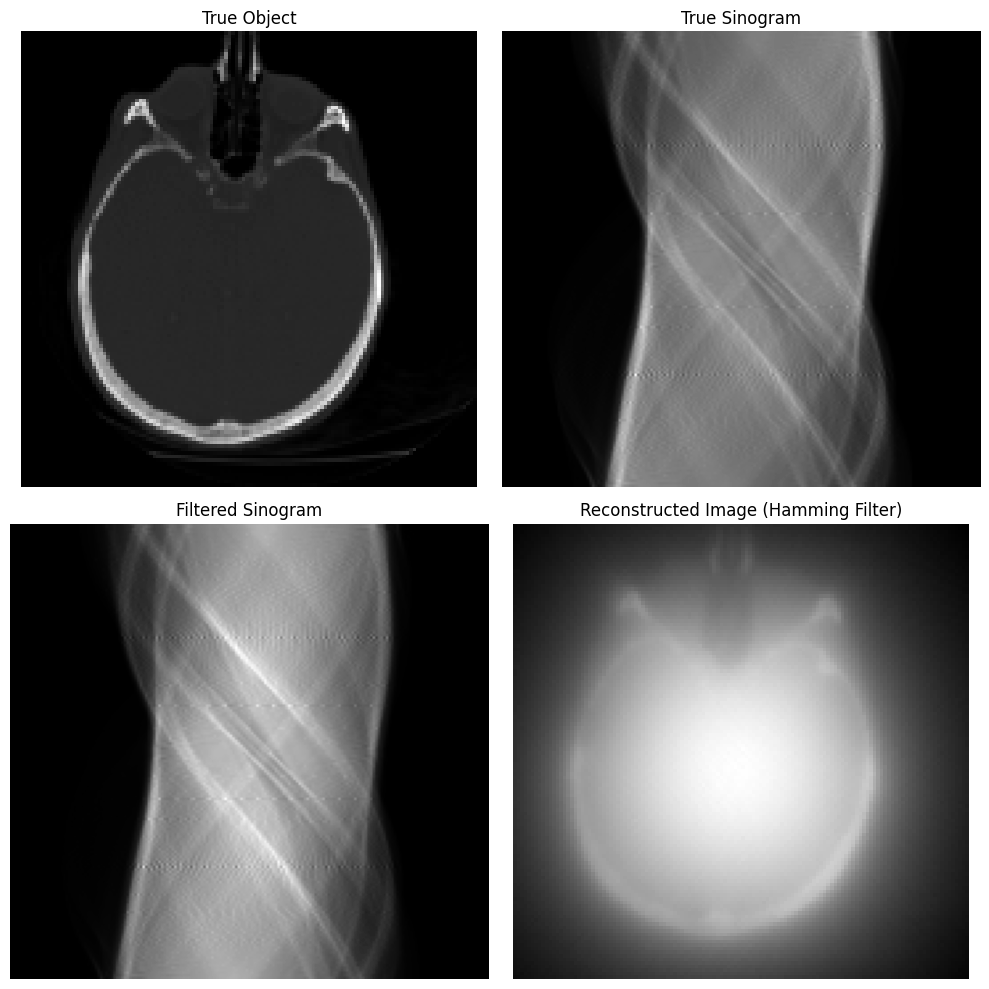

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(true_object_np, cmap='gray')
axs[0, 0].set_title('True Object')
axs[0, 0].axis('off')

axs[0, 1].imshow(true_sinogram_np, cmap='gray', aspect='auto')
axs[0, 1].set_title('True Sinogram')
axs[0, 1].axis('off')

axs[1, 0].imshow(hamming_filtered_sinogram_np, cmap='gray', aspect='auto')
axs[1, 0].set_title('Filtered Sinogram')
axs[1, 0].axis('off')

axs[1, 1].imshow(recon_np_hamming_filtered, cmap='gray')
axs[1, 1].set_title('Reconstructed Image (Hamming Filter)')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

b) Ram-Lak Filter:

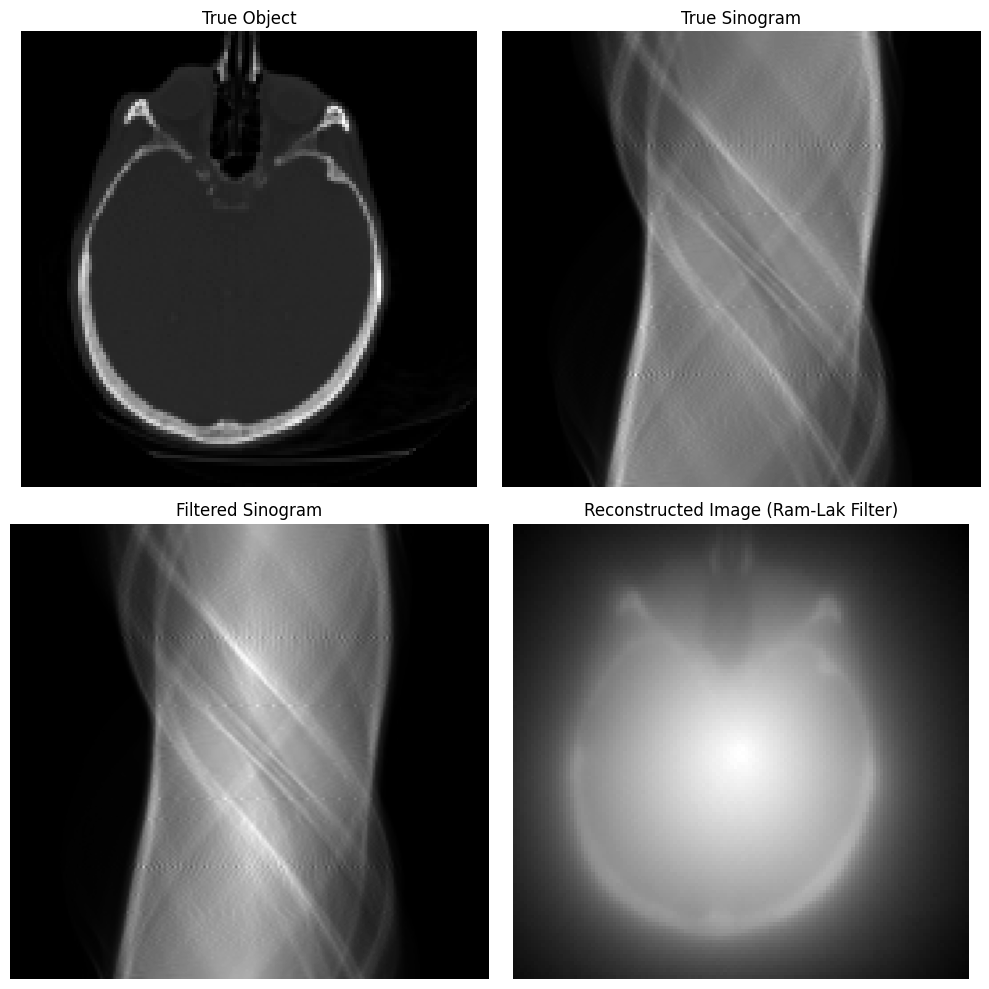

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(true_object_np, cmap='gray')
axs[0, 0].set_title('True Object')
axs[0, 0].axis('off')

axs[0, 1].imshow(true_sinogram_np, cmap='gray', aspect='auto')
axs[0, 1].set_title('True Sinogram')
axs[0, 1].axis('off')

axs[1, 0].imshow(ramlak_filtered_sinogram_np, cmap='gray', aspect='auto')
axs[1, 0].set_title('Filtered Sinogram')
axs[1, 0].axis('off')

axs[1, 1].imshow(recon_np_ramlak_filtered, cmap='gray')
axs[1, 1].set_title('Reconstructed Image (Ram-Lak Filter)')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

c) Shepp-Logan Filter:

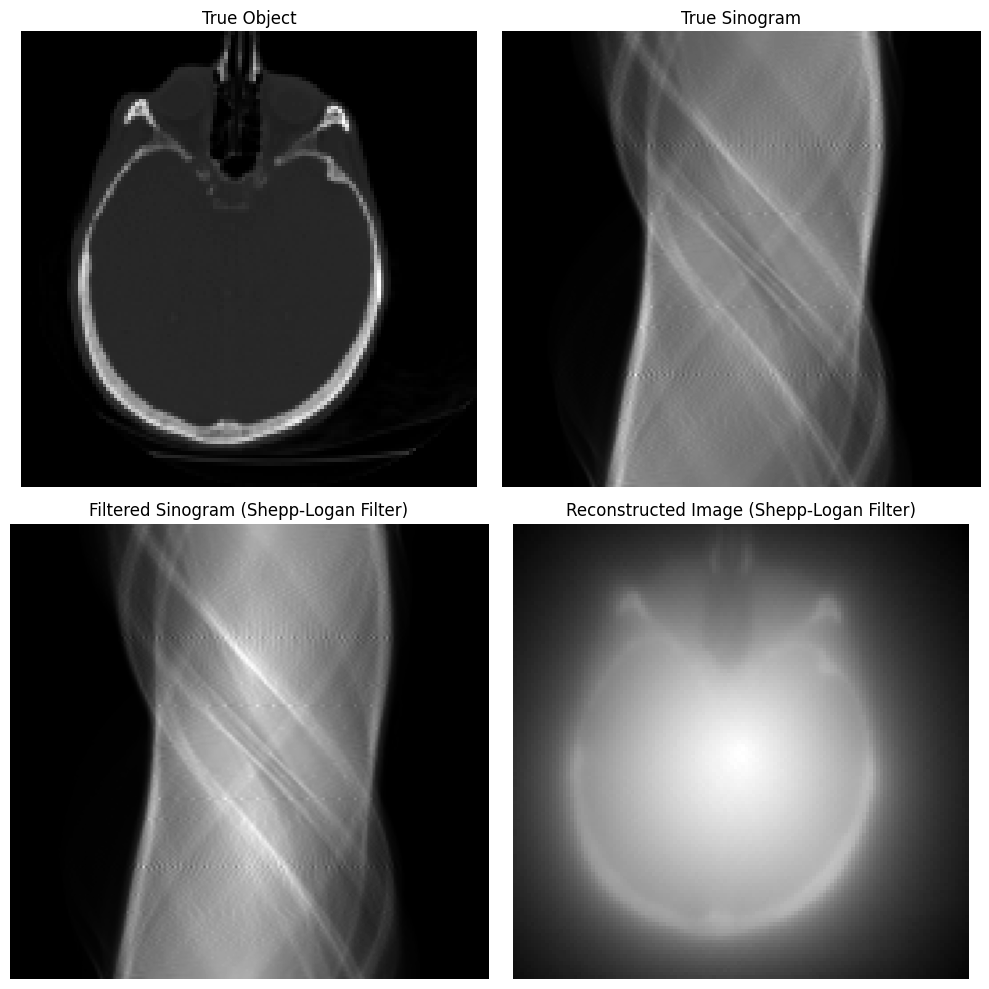

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(true_object_np, cmap='gray')
axs[0, 0].set_title('True Object')
axs[0, 0].axis('off')

axs[0, 1].imshow(true_sinogram_np, cmap='gray', aspect='auto')
axs[0, 1].set_title('True Sinogram')
axs[0, 1].axis('off')

axs[1, 0].imshow(shepp_logan_filtered_sinogram_np, cmap='gray', aspect='auto')
axs[1, 0].set_title('Filtered Sinogram (Shepp-Logan Filter)')
axs[1, 0].axis('off')

axs[1, 1].imshow(recon_np_shepp_logan_filtered, cmap='gray')
axs[1, 1].set_title('Reconstructed Image (Shepp-Logan Filter)')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


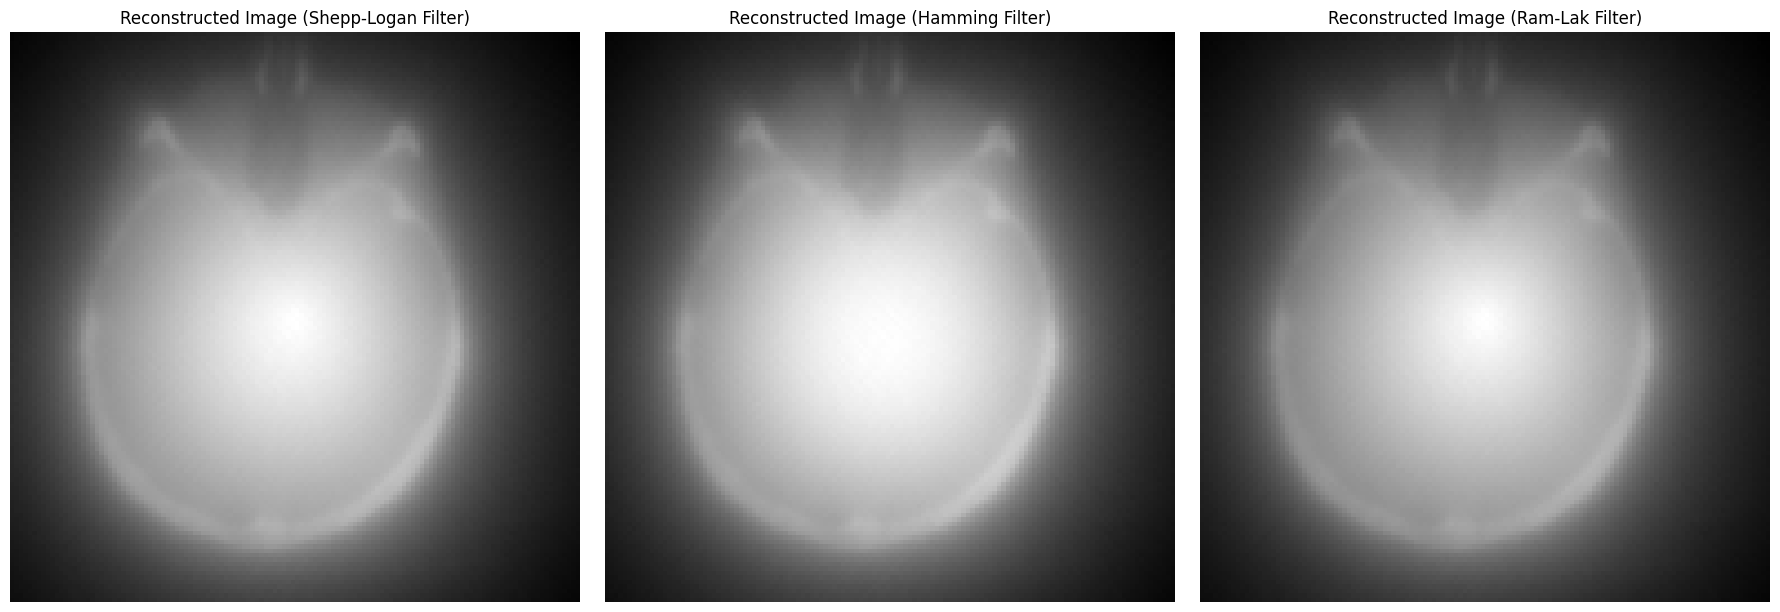

SSIM Hamming Filtered: 0.0000000619
SSIM Ram-Lak Filtered: 0.0000004201
SSIM Shepp-Logan Filtered: 0.0000022224
Correlation Coefficient (CC) Hamming Filtered: 0.5740409980065688
Correlation Coefficient (CC) Ram-Lak Filtered: 0.5692856686711291
Correlation Coefficient (CC) Shepp-Logan Filtered: 0.5807267041527738
Mean Squared Error (MSE) Hamming Filtered (Normalized): 0.1791431985
Mean Squared Error (MSE) Ram-Lak Filtered (Normalized): 0.1385712217
Mean Squared Error (MSE) Shepp-Logan Filtered (Normalized): 0.1532970474
Mean Absolute Error (MAE) Hamming Filtered (Normalized): 0.3597755360
Mean Absolute Error (MAE) Ram-Lak Filtered (Normalized): 0.3158745658
Mean Absolute Error (MAE) Shepp-Logan Filtered (Normalized): 0.3341388539


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(recon_np_shepp_logan_filtered, cmap='gray')
axs[0].set_title('Reconstructed Image (Shepp-Logan Filter)')
axs[0].axis('off')

axs[1].imshow(recon_np_hamming_filtered, cmap='gray')
axs[1].set_title('Reconstructed Image (Hamming Filter)')
axs[1].axis('off')

axs[2].imshow(recon_np_ramlak_filtered, cmap='gray')
axs[2].set_title('Reconstructed Image (Ram-Lak Filter)')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Compute SSIM for recon_np_hamming_filtered
ssim_hamming = ssim(true_object_np, recon_np_hamming_filtered, data_range=true_object_np.max() - true_object_np.min())

# Compute SSIM for recon_np_ramlak_filtered
ssim_ramlak = ssim(true_object_np, recon_np_ramlak_filtered, data_range=true_object_np.max() - true_object_np.min())

# Compute SSIM for recon_np_shepp_logan_filtered
ssim_shepp_logan = ssim(true_object_np, recon_np_shepp_logan_filtered, data_range=true_object_np.max() - true_object_np.min())

print("SSIM Hamming Filtered: {:.10f}".format(ssim_hamming))
print("SSIM Ram-Lak Filtered: {:.10f}".format(ssim_ramlak))
print("SSIM Shepp-Logan Filtered: {:.10f}".format(ssim_shepp_logan))

# Compute Correlation Coefficient (CC)
cc_hamming = np.corrcoef(true_object_np.flatten(), recon_np_hamming_filtered.flatten())[0, 1]
cc_ramlak = np.corrcoef(true_object_np.flatten(), recon_np_ramlak_filtered.flatten())[0, 1]
cc_shepp_logan = np.corrcoef(true_object_np.flatten(), recon_np_shepp_logan_filtered.flatten())[0, 1]

print("Correlation Coefficient (CC) Hamming Filtered:", cc_hamming)
print("Correlation Coefficient (CC) Ram-Lak Filtered:", cc_ramlak)
print("Correlation Coefficient (CC) Shepp-Logan Filtered:", cc_shepp_logan)

# Normalize the images to the range [0, 1]
true_object_np_normalized = (true_object_np - true_object_np.min()) / (true_object_np.max() - true_object_np.min())
recon_np_hamming_filtered_normalized = (recon_np_hamming_filtered - recon_np_hamming_filtered.min()) / (recon_np_hamming_filtered.max() - recon_np_hamming_filtered.min())
recon_np_ramlak_filtered_normalized = (recon_np_ramlak_filtered - recon_np_ramlak_filtered.min()) / (recon_np_ramlak_filtered.max() - recon_np_ramlak_filtered.min())
recon_np_shepp_logan_filtered_normalized = (recon_np_shepp_logan_filtered - recon_np_shepp_logan_filtered.min()) / (recon_np_shepp_logan_filtered.max() - recon_np_shepp_logan_filtered.min())

# Compute MSE and MAE for normalized images
mse_hamming_normalized = mean_squared_error(true_object_np_normalized, recon_np_hamming_filtered_normalized)
mse_ramlak_normalized = mean_squared_error(true_object_np_normalized, recon_np_ramlak_filtered_normalized)
mse_shepp_logan_normalized = mean_squared_error(true_object_np_normalized, recon_np_shepp_logan_filtered_normalized)

mae_hamming_normalized = mean_absolute_error(true_object_np_normalized, recon_np_hamming_filtered_normalized)
mae_ramlak_normalized = mean_absolute_error(true_object_np_normalized, recon_np_ramlak_filtered_normalized)
mae_shepp_logan_normalized = mean_absolute_error(true_object_np_normalized, recon_np_shepp_logan_filtered_normalized)

print("Mean Squared Error (MSE) Hamming Filtered (Normalized): {:.10f}".format(mse_hamming_normalized))
print("Mean Squared Error (MSE) Ram-Lak Filtered (Normalized): {:.10f}".format(mse_ramlak_normalized))
print("Mean Squared Error (MSE) Shepp-Logan Filtered (Normalized): {:.10f}".format(mse_shepp_logan_normalized))

print("Mean Absolute Error (MAE) Hamming Filtered (Normalized): {:.10f}".format(mae_hamming_normalized))
print("Mean Absolute Error (MAE) Ram-Lak Filtered (Normalized): {:.10f}".format(mae_ramlak_normalized))
print("Mean Absolute Error (MAE) Shepp-Logan Filtered (Normalized): {:.10f}".format(mae_shepp_logan_normalized))

